<h3> Machine Learning Project 6 </h3>
    <p> Liora Wachsstock </p>
    

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#constants
UPPER = 10
LOWER = -2

In [3]:
def generate_data(n):
    rng = np.random.default_rng()
    x = (UPPER - LOWER) * rng.random(n) + LOWER
    y = f(x)
    data = np.stack((x, y), axis=-1)
    
    return pd.DataFrame(data, columns=("X", "Y"))

def f(x):
    return np.square(x) + 10

#generate data
train = generate_data(12)
test = generate_data(5)

#check for intersecting values and re-sample if necessary
while (np.intersect1d(train.T[0], test.T[0]).size > 0): #only have to check if there are identical values in x values
    print(np.intersect1d(train.T[0], test.T[0]))
    test = generate_data(5)

print(train)
print(test)

           X           Y
0   2.230615   14.975643
1   6.052691   46.635064
2   9.407758   98.505910
3   8.111259   75.792516
4   9.676441  103.633511
5   9.533637  100.890226
6   7.047249   59.663715
7   5.145910   36.480389
8   9.721188  104.501497
9   6.143530   47.742960
10  7.183659   61.604961
11  1.374302   11.888707
          X           Y
0  0.577604   10.333626
1  5.447404   39.674208
2  9.994445  109.888925
3  1.495936   12.237825
4  9.253523   95.627693


In [4]:
def quadratic_regression(data):
    #math from https://www.varsitytutors.com/hotmath/hotmath_help/topics/quadratic-regression
    
    powers = np.array([4,3,2,3,2,1,2,1,0])
    
    #repeat each of the x values 9 times for the powers
    x_s = np.repeat(np.array(data['X']), [powers.size]).reshape(data['X'].size, powers.size) 
    
    coeff_m = np.sum(np.power(x_s, powers), axis=0).reshape(3,3)
    
    y_col = np.vstack((np.sum(np.square(data['X'])*data['Y']), np.sum(data['X']*data['Y']), np.sum(data['Y'])))
    
    result = np.matmul(np.linalg.inv(coeff_m), y_col)
    print(result)
    return result

def g(abc, x): # create the actual hypothesis line
    a,b,c = abc
    y = a*np.square(x) + b*x + c # equation of the curve
    return y

def curve(abc):
    x = np.arange(-25, 25 ) # points on the curve
    y = g(abc, x) # equation of the estimated y
    return x,y

def e_out(data, weights):
    yhat = g(weights, data['X'])
    return np.sum(np.square(data['Y'] - yhat)) #SSE

def e_reg(lam, data, weights):
    return e_out(data, weights) + lam*np.sum(np.square(weights))
'''
cross validation: 
take out a validation set from the training set, and find the best line from all the hypothesis that makes the smallest
error in the validation set and use its model family
then take the validation set and re run the learning with the best model. s
'''

'\ncross validation: \ntake out a validation set from the training set, and find the best line from all the hypothesis that makes the smallest\nerror in the validation set and use its model family\nthen take the validation set and re run the learning with the best model. s\n'

In [24]:
def ridge_reg(lam, x_series, y):
    
    #add a dummy x0 = 1
    x = np.array(x_series).reshape(x_series.size,1)
    x = np.insert(x, 0,1,axis=1)

    return np.dot(np.linalg.inv(np.dot(x.T, x) + lam*np.identity(x.shape[1])), np.dot(x.T, y))
    

def get_validation_data(data, group_num, k):
    num_in_group = int(np.floor(data.shape[0] / k))
    v_data = data[group_num*num_in_group: group_num*num_in_group + num_in_group]
    tr_data1 = data[:group_num*num_in_group]
    tr_data2 = data[group_num*num_in_group + num_in_group :]
    tr_data = np.vstack((tr_data1, tr_data2))
    return v_data, pd.DataFrame(tr_data, columns=("X", "Y"))

[[ 1.0000000e+00]
 [-5.1159077e-13]
 [ 1.0000000e+01]]
(19350.58710046116, array([ 0.        , -0.28161259,  9.29250907]))
Training Error for Quadratic regression:  3.0422253571336413e-23
Training Error for ridge regression:  19350.58710046116


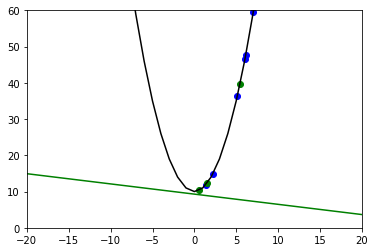

In [34]:
fig, ax = plt.subplots()
plt.xlim([-20,20])
plt.ylim([0,60])

k = 3

# plot the points
ax.scatter(train['X'], train['Y'], c='b')
ax.scatter(test['X'], test['Y'], c='g')

# quadratic regression
result = quadratic_regression(train)
x, y = curve(result)

lams = [0.1, 1, 10, 100]

models = []

for lam in lams:
    error_history = []
    for i in range(k - 1): #k groups, so k - 1 divisions of the data needed
        validation_set, train_set = get_validation_data(train, i, k)
        rdge = ridge_reg(lam, train_set['X'], train_set['Y'])
        
        lin_reg_result = np.insert(rdge, 0, 0) # add in a zero a term so it's a straight line
        error_history.append(e_reg(lam, validation_set, lin_reg_result))
    
    #for this model, get Rcv
    R_cv = np.mean(error_history)
    
    #re-train on the whole data set
    rdge = ridge_reg(lam, train_set['X'], train_set['Y'])  
    lin_reg_result = np.insert(rdge, 0, 0) # add in a zero a term so it's a straight line

    models.append((R_cv, lin_reg_result)) #keep track of R and g(x) for each set
    
model = min(models, key = lambda t: t[0]) # get the one with the smallest R
print(model)
final_result = model[1] #line


# plot the lines/curves
ax.plot(x, y, 'k',label="f(x) = x^2 + 10")
xlin, ylin = curve(final_result)
ax.plot(xlin, ylin, 'g')

#for line in lines:
  #  xlin, ylin = curve(line)
  #  ax.plot(xlin, ylin, 'g')



print("Training Error for Quadratic regression: ", e_out(train, result))
print("Training Error for ridge regression: ", model[0])
plt.show()